# Deliverable D4.12
## Release of the tool for the automatic semantic description of music samples

### Updates to pitch confidence

In [28]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
from collections import defaultdict
seaborn.set(style="whitegrid")
%matplotlib inline
dataset_dirnames = ['iowa_instrument_samples', 'carlos_vaquero_instrument_samples', 'philharmonic_orchestra_samples', 'nsynth-test', 'nsynth-valid','good-sounds'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)
methods_to_compare = ['EssentiaPitchYin','EssentiaPitchYinFFT', 'ACExtractorV1','ACExtractorV2', 'QMULpyin', 'ACExtractorV3_dev', 'ACExtractorV3']
accuracy_functions = [exact_match, pitch_class]
accuracy_functions_names = ['Exact', 'PitchClass']

DISPLAY_NAMES = {
    'ACExtractorV1': 'ACExtractorV1',
    'ACExtractorV2': 'ACExtractorV2',
    'ACExtractorV3_dev': 'ACExtractorV3dev',
    'ACExtractorV3': 'ACExtractorV3',
    'QMULpyin': 'QMULPYin',
    'EssentiaPitchYinFFT': 'ESSPYinFFT',
    'EssentiaPitchYin': 'ESSPYin',
}

datasets = [dataset for dataset in datasets if len(dataset.get_data('analysis.ACExtractorV3_dev')) == len(dataset.data) and len(dataset.get_data('analysis.ACExtractorV3')) == len(dataset.data)]
print(len(datasets))

np.warnings.filterwarnings('ignore')

6




General pitch estimation results (IOWA)
****************************************


Method             Exact   PitchClass   
----------------------------------------
ACExtractorV3      79.04   81.93        
ESSPYin            76.87   80.96        
ACExtractorV3dev   75.18   78.07        
QMULPYin           71.57   74.94        
ACExtractorV1      70.60   73.25        
ACExtractorV2      67.71   71.57        
ESSPYinFFT         66.99   68.92        


General pitch estimation results (CVAQ)
****************************************


Method             Exact   PitchClass   
----------------------------------------
ACExtractorV3      56.27   83.63        
QMULPYin           54.48   82.61        
ACExtractorV3dev   54.22   80.31        
ESSPYin            51.92   79.28        
ESSPYinFFT         44.25   66.50        
ACExtractorV1      34.53   53.45        
ACExtractorV2      34.53   53.45        


General pitch estimation results (PHIL)
****************************************


Method 

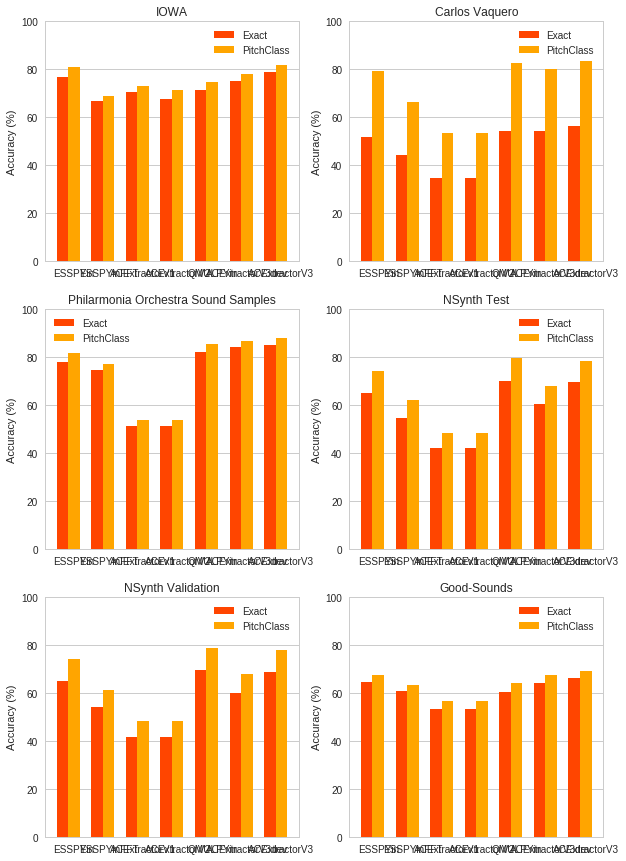

In [29]:
all_datasets_method_results = dict()
all_datasets_method_results_stats = defaultdict(list)
fig1, axs = plt.subplots(3, 2, figsize=(10, 15))
for count, dataset in enumerate(datasets):
    print(title("\nGeneral pitch estimation results (%s)" % dataset.short_name, c='*'))
    table_header = ['Method'] + accuracy_functions_names
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = defaultdict(list)
            all_datasets_method_results_stats[method] = defaultdict(list)
        try:
            table_row = [DISPLAY_NAMES.get(method, method)]
            for accuracy_func in accuracy_functions:
                method_results = accuracy_func(dataset.data, method)
                acc_method_avg = 100 * basic_statistics(method_results)['avg']
                table_row.append(acc_method_avg)
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
                all_datasets_method_results_stats[method][accuracy_func.__name__].append(acc_method_avg)
            table_rows.append(table_row)
        except IndexError:
            print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print("")
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)
    
    # Plot results
    ax = axs[count//2,count%2]
    N = len(methods_to_compare)
    ind = np.arange(N)
    rects = list()
    width = 1.0 / (len(accuracy_functions) + 1)
    for i in range(0, len(accuracy_functions)):
        means = [row[i+1] for row in table_rows]
        rects.append(ax.bar(ind + i * width, means, width, color=COLORS[i]))
    ax.set_title(dataset.name)
    ax.set_xticks(ind + (width * len(accuracy_functions) * 1.0)/2)
    ax.set_xticklabels([DISPLAY_NAMES.get(method, method) for method in methods_to_compare], rotation=0)
    ax.legend([rect[0] for rect in rects], accuracy_functions_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)

In [18]:
print(title("General pitch estimation results (ALL DATASETS)"))
table_header = ['Method'] + accuracy_functions_names + ['Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results_stats.items():
    table_row = [DISPLAY_NAMES.get(method, method)]
    for accuracy_measure in [f.__name__ for f in accuracy_functions]:
        data = results[accuracy_measure]
        table_row.append(basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=-1, highlight_max=True)


General pitch estimation results (ALL DATASETS)
-----------------------------------------------

Method          Exact   PitchClass   Mean accuracy   
-----------------------------------------------------
QMULPYin        67.70   77.35        72.52           
ACExtractorV3   67.60   76.08        71.84           
ESSPYin         52.51   61.29        56.90           
ACExtractorV1   50.30   57.06        53.68           
ACExtractorV2   50.24   57.04        53.64           
ESSPYinFFT      46.15   53.04        49.59           


In [30]:
# Pre-process extra confidence measures

for dataset in datasets:
    for sound in dataset.data.values():
        sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_mean'] = sound['analysis']['ACExtractorV3_dev']['note_pitch_instantaneous_confidence_mean']
        sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_median'] = sound['analysis']['ACExtractorV3_dev']['note_pitch_instantaneous_confidence_median']
        sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_median_adj'] = (sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_median'] - 0.5) * 2
        sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_mean_se'] = sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_mean'] if sound['analysis']['ACExtractorV3_dev']['single_event'] else 0.0
        sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_median_se'] = sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_median'] if sound['analysis']['ACExtractorV3_dev']['single_event'] else 0.0
        sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_median_adj_se'] = sound['analysis']['ACExtractorV3_dev']['note_confidence_ic_median_adj'] if sound['analysis']['ACExtractorV3_dev']['single_event'] else 0.0

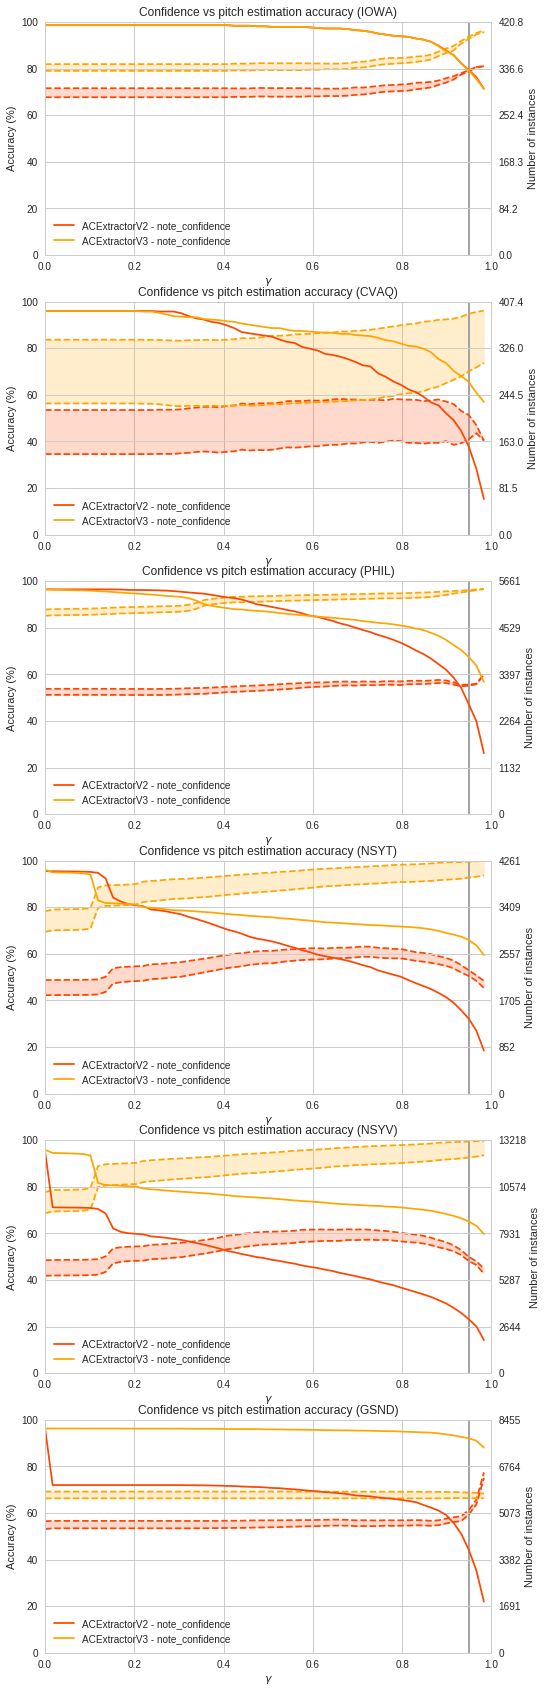

In [31]:
# Accuracy vs confidence per dataset

fig1, axs = plt.subplots(len(datasets), 1, figsize=(8, 5*len(datasets)))
for count, dataset in enumerate(datasets):
    try:
        ax1 = axs[count]
    except TypeError:
        ax1 = axs
    ax2 = ax1.twinx()
    for count, (method, conf_measure_field) in enumerate([('ACExtractorV2', 'note_confidence'), 
                                                          #('ACExtractorV3_dev', 'note_confidence_ic_median'),
                                                          #('ACExtractorV3_dev', 'note_confidence_ic_mean'),
                                                          #('ACExtractorV3_dev', 'note_confidence_ic_median_se'),
                                                          #('ACExtractorV3_dev', 'note_confidence_ic_median'),
                                                          ('ACExtractorV3', 'note_confidence'),
                                                          #('ACExtractorV3_dev', 'note_confidence_ic_median_adj_se'),
                                                          #('ACExtractorV3_dev', 'note_confidence_ic_mean_se'),
                                                          #('ACExtractorV3_dev', 'note_confidence_ic_median_se_var'),
                                                         ]):
        exact = list()
        pclass = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        steps_plot = list()
        for conf_min in steps:
            try:
                #print(max(dataset.get_data('analysis.ACExtractorV2.note_confidence')))
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_measure_field), conf_min)]).data
                if len(filtered_data) >= len(dataset.data) * 0.05:
                    exact.append(100 * basic_statistics(exact_match(filtered_data, method))['avg'])
                    pclass.append(100 * basic_statistics(pitch_class(filtered_data, method))['avg'])
                    counts.append(len(filtered_data))
                    steps_plot.append(conf_min)
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps_plot, exact, color=COLORS[count], ls="--")
        ax1.plot(steps_plot, pclass, color=COLORS[count], ls="--")
        ax1.fill_between(steps_plot, exact, pclass, color=COLORS[count], alpha=0.2)
        ax2.plot(steps_plot, counts, color=COLORS[count], label='{0} - {1}'.format(method, conf_measure_field))

    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    ax1.set_xlim(0.0, 1.0)
    ax1.set_title('Confidence vs pitch estimation accuracy (%s)' % dataset.short_name)

In [33]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in ['ACExtractorV2', 'ACExtractorV3_dev', 'ACExtractorV3']:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'note_confidence'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(exact_match(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(pitch_class(filtered_data, method))['avg']
        except IndexError:
            print('Unable to compute results for method %s and dataset %s' % (method, dataset.short_name))
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
        
        #print(dataset.short_name)
        #print('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)

print_table(table_header, table_rows)

Method              IOWA                      CVAQ                      PHIL                      NSYT                      NSYV                      GSND                      
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ACExtractorV2       A=78.74 - 79.34%, N=80%   A=40.52 - 50.98%, N=39%   A=55.14 - 55.56%, N=49%   A=50.29 - 52.79%, N=33%   A=48.08 - 49.85%, N=24%   A=59.48 - 61.40%, N=45%   
ACExtractorV3_dev   A=97.08 - 97.08%, N=33%   A=80.39 - 94.12%, N=39%   A=94.31 - 94.76%, N=49%   A=91.19 - 99.41%, N=33%   A=91.23 - 99.38%, N=24%   A=70.17 - 71.87%, N=15%   
ACExtractorV3       A=92.79 - 93.69%, N=80%   A=70.45 - 95.08%, N=68%   A=95.67 - 96.14%, N=70%   A=92.80 - 99.54%, N=69%   A=92.60 - 99.48%, N=68%   A=66.37 - 68.76%, N=96%   
